In [3]:
import numpy as np
import numpy.linalg as la
from scipy.sparse import diags
import matplotlib.pyplot as plt

def get_xs(base):
    inFile = base + 'DIFFCOEF.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    D = float(lines[0][1]), float(lines[0][2])

    inFile = base + 'REMXS.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    sr = float(lines[0][1]), float(lines[0][2])

    inFile = base + 'SP0.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    # sigmaS21, sigmaS12
    ss = float(lines[0][3]), float(lines[0][2])

    inFile = base + 'CHIT.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    chi = float(lines[0][1]), float(lines[0][2])

    inFile = base + 'NSF.txt'
    with open(inFile, 'r') as i:
        data = i.readlines()
    lines = list()
    for line in data:
        lines.append(line.split())
    nusf = float(lines[0][1]), float(lines[0][2])
    
    return D, sr, ss, chi, nusf

# 2 Groups, 1 Region

In [3]:
base = '../xs/8/xs800000-500-100/htgr_2g_'
cD, csr, css, cchi, cnusf = get_xs(base + 'homoge_')

i =  356
k =  1.4152965641775215
0.17645760636291344


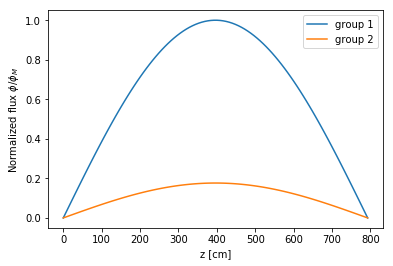

In [4]:
# Build system
N = 100
x = np.linspace(0, 793, num=N)
hx = x[1]-x[0]
hx2 = hx**2

# Diffusion matrix
DM1 = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
DM2 = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
D = np.zeros((2*N,2*N))
D[:N,:N] = cD[0]/hx2 * DM1
D[N:2*N,N:2*N] = cD[1]/hx2 * DM2

# Removal
SR = np.eye(2*N)
SR[:N,:N] = -csr[0] * SR[:N,:N]
SR[N:2*N,N:2*N] = -csr[1] * SR[N:2*N,N:2*N]

# In-scattering
aux1 = np.eye(N)
SS = np.zeros((2*N,2*N))
# No up-scattering for the moment
SS[:N,N:2*N] = css[0] * aux1
SS[N:2*N,:N] = css[1] * aux1

# Fission
F = np.zeros((2*N,2*N))
F[:N,:N] = cnusf[0] * aux1
F[:N,N:2*N] =  cnusf[1] * aux1

# Apply BCs
LHS = D + SR + SS
LHS[0] = np.zeros(2*N)
LHS[0, 0] = 1.0
LHS[N-1] = np.zeros(2*N)
LHS[N-1, N-1] = 1.0
LHS[N] = np.zeros(2*N)
LHS[N, N] = 1.0
LHS[2*N-1] = np.zeros(2*N)
LHS[2*N-1, 2*N-1] = 1.0

F[0] = np.zeros(2*N)
F[N-1] = np.zeros(2*N)
F[N] = np.zeros(2*N)
F[2*N-1] = np.zeros(2*N)

k = 1.0
flux_old = np.ones(2*N)
RHS = -F @ flux_old

def converged(k_old, k):
    if abs((k - k_old)/k_old) <= 1e-12:
        return True
    else:
        return False

for i in range(1000):
    k_old = k
    flux_new = np.linalg.solve(LHS, RHS)
    kp = sum((F @ flux_new)[:N])/sum((F @ flux_old)[:N])
    k = k_old * kp
    RHS = -(1/k) * F @ flux_new
    flux_old = flux_new
    if converged(k_old, k) == True:
        break

print('i = ', i)
print('k = ', k)
        
flux1 = flux_old[:N]
M = max(flux1)
flux1 /= M
flux2 = flux_old[N:2*N]
flux2 /= M

print(max(flux2)/max(flux1))

plt.plot(x, flux1, label='group 1')
plt.plot(x, flux2, label='group 2')
plt.legend(loc='upper right')
plt.ylabel(r"Normalized flux $\phi/\phi_M$")
plt.xlabel("z [cm]")
# plt.savefig("1D-fuel-eig-FDM", dpi=300, bbox_inches="tight")
plt.show()

# 2 Groups, 3 Regions

In [12]:
base = '../xs/8/xs800000-500-100/htgr_2g_'
cD, csr, css, cchi, cnusf = get_xs(base + 'homoge_')
bD, bsr, bss, bchi, bnusf = get_xs(base + 'brefl_')
tD, tsr, tss, tchi, tnusf = get_xs(base + 'trefl_')

i =  695
k =  1.4242801801349354


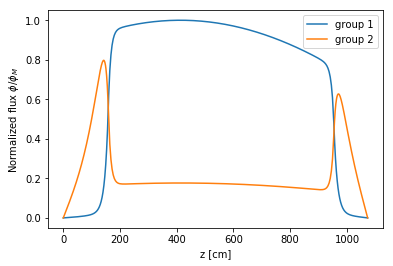

In [13]:
# Build system
Nb = 200
xb = np.linspace(0, 160, num=Nb)
# print(xb)
hb = xb[1]-xb[0]
hb2 = hb**2

Nc = 200
xc = np.linspace(160, 160+793, num=Nc)
# print(xc)
hc = xc[1]-xc[0]
hc2 = hc**2

Nt = 200
xt = np.linspace(160+793, 160+793+120, num=Nt)
# print(xt)
ht = xt[1]-xt[0]
ht2 = ht**2

N = Nb + Nc + Nt
x = np.concatenate([xb, xc, xt])
# print(N)
# print(x)

# Diffusion matrix
D = np.zeros((2*N, 2*N))
DM = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
# Diffusion matrix: g = 1
D[:N, :N] = DM
D[:Nb] *= bD[0]/hb2
D[Nb:Nb+Nc] *= cD[0]/hc2
D[Nb+Nc:Nb+Nc+Nt] *= tD[0]/ht2
# Diffusion matrix: g = 2
D[N:2*N, N:2*N] = DM
D[N:N+Nb] *= bD[1]/hb2
D[N+Nb:N+Nb+Nc] *= cD[1]/hc2
D[N+Nb+Nc:N+Nb+Nc+Nt] *= tD[1]/ht2

# Removal
SR = np.eye(2*N)
# Removal: g = 1
SR[:Nb, :Nb] *= -bsr[0]
SR[Nb:Nb+Nc, Nb:Nb+Nc] *= -csr[0]
SR[Nb+Nc:Nb+Nc+Nt, Nb+Nc:Nb+Nc+Nt] *= -tsr[0]
# Removal: g = 2
SR[N:N+Nb, N:N+Nb] *= -bsr[1]
SR[N+Nb:N+Nb+Nc, N+Nb:N+Nb+Nc] *= -csr[1]
SR[N+Nb+Nc:N+Nb+Nc+Nt, N+Nb+Nc:N+Nb+Nc+Nt] *= -tsr[1]

# In-scattering
aux1 = np.eye(N)
SS = np.zeros((2*N, 2*N))
# In-scattering: g = 1: \Sigma^s_{21}
SS[:N, N:2*N] = aux1
SS[:Nb] *= bss[0]
SS[Nb:Nb+Nc] *= css[0]
SS[Nb+Nc:Nb+Nc+Nt] *= tss[0]
# In-scattering: g = 2: \Sigma^s_{12}
SS[N:2*N, :N] = aux1
SS[N:N+Nb] *= bss[1]
SS[N+Nb:N+Nb+Nc] *= css[1]
SS[N+Nb+Nc:N+Nb+Nc+Nt] *= tss[1]

# Fission
F = np.zeros((2*N,2*N))
# Fission: g = 1
F[Nb:Nb+Nc, Nb:Nb+Nc] = cchi[0] * cnusf[0] * aux1[Nb:Nb+Nc, Nb:Nb+Nc]
F[Nb:Nb+Nc, N+Nb:N+Nb+Nc] = cchi[0] * cnusf[1] * aux1[Nb:Nb+Nc, Nb:Nb+Nc]
# Fission: g = 2
F[N+Nb:N+Nb+Nc, Nb:Nb+Nc] = cchi[1] * cnusf[0] * aux1[Nb:Nb+Nc, Nb:Nb+Nc]
F[N+Nb:N+Nb+Nc, N+Nb:N+Nb+Nc] = cchi[1] * cnusf[1] * aux1[Nb:Nb+Nc, Nb:Nb+Nc]

# Apply BCs
LHS = D + SR + SS

# group 1
LHS[0] = np.zeros(2*N)
LHS[0, 0] = 1.0

LHS[Nb-1] = np.zeros(2*N)
LHS[Nb-1, Nb-3] = 1./2/hb*bD[0]
LHS[Nb-1, Nb-2] = -2./hb*bD[0]
LHS[Nb-1, Nb-1] = 3./2/hb*bD[0]
LHS[Nb-1, Nb] = 3./2/hc*cD[0]
LHS[Nb-1, Nb+1] = -2./hc*cD[0]
LHS[Nb-1, Nb+2] = 1./2/hc*cD[0]

LHS[Nb] = np.zeros(2*N)
LHS[Nb, Nb-1] = -1.0
LHS[Nb, Nb] = 1.0

LHS[Nb+Nc-1] = np.zeros(2*N)
LHS[Nb+Nc-1, Nb+Nc-3] = 1./2/hc*cD[0]
LHS[Nb+Nc-1, Nb+Nc-2] = -2./hc*cD[0]
LHS[Nb+Nc-1, Nb+Nc-1] = 3./2/hc*cD[0]
LHS[Nb+Nc-1, Nb+Nc] = 3./2/ht*tD[0]
LHS[Nb+Nc-1, Nb+Nc+1] = -2./ht*tD[0]
LHS[Nb+Nc-1, Nb+Nc+2] = 1./2/ht*tD[0]

LHS[Nb+Nc] = np.zeros(2*N)
LHS[Nb+Nc, Nb+Nc-1] = -1.0
LHS[Nb+Nc, Nb+Nc] = 1.0

LHS[Nb+Nc+Nt-1] = np.zeros(2*N)
LHS[Nb+Nc+Nt-1, Nb+Nc+Nt-1] = 1.0

# group 2
LHS[N] = np.zeros(2*N)
LHS[N, N] = 1.0

LHS[N+Nb-1] = np.zeros(2*N)
LHS[N+Nb-1, N+Nb-3] = 1./2/hb*bD[1]
LHS[N+Nb-1, N+Nb-2] = -2./hb*bD[1]
LHS[N+Nb-1, N+Nb-1] = 3./2/hb*bD[1]
LHS[N+Nb-1, N+Nb] = 3./2/hc*cD[1]
LHS[N+Nb-1, N+Nb+1] = -2./hc*cD[1]
LHS[N+Nb-1, N+Nb+2] = 1./2/hc*cD[1]

LHS[N+Nb] = np.zeros(2*N)
LHS[N+Nb, N+Nb-1] = -1.0
LHS[N+Nb, N+Nb] = 1.0

LHS[N+Nb+Nc-1] = np.zeros(2*N)
LHS[N+Nb+Nc-1, N+Nb+Nc-3] = 1./2/hc*cD[1]
LHS[N+Nb+Nc-1, N+Nb+Nc-2] = -2./hc*cD[1]
LHS[N+Nb+Nc-1, N+Nb+Nc-1] = 3./2/hc*cD[1]
LHS[N+Nb+Nc-1, N+Nb+Nc] = 3./2/ht*tD[1]
LHS[N+Nb+Nc-1, N+Nb+Nc+1] = -2./ht*tD[1]
LHS[N+Nb+Nc-1, N+Nb+Nc+2] = 1./2/ht*tD[1]

LHS[N+Nb+Nc] = np.zeros(2*N)
LHS[N+Nb+Nc, N+Nb+Nc-1] = -1.0
LHS[N+Nb+Nc, N+Nb+Nc] = 1.0

LHS[N+Nb+Nc+Nt-1] = np.zeros(2*N)
LHS[N+Nb+Nc+Nt-1, N+Nb+Nc+Nt-1] = 1.0

#
F[0] = np.zeros(2*N)
F[Nb-1] = np.zeros(2*N)
F[Nb] = np.zeros(2*N)
F[Nb+Nc-1] = np.zeros(2*N)
F[Nb+Nc] = np.zeros(2*N)
F[Nb+Nc+Nt-1] = np.zeros(2*N)

F[N] = np.zeros(2*N)
F[N+Nb-1] = np.zeros(2*N)
F[N+Nb] = np.zeros(2*N)
F[N+Nb+Nc-1] = np.zeros(2*N)
F[N+Nb+Nc] = np.zeros(2*N)
F[2*N-1] = np.zeros(2*N)

k = 1.0
flux_old = np.ones(2*N)
RHS = -F @ flux_old

def converged(k_old, k):
    if abs((k - k_old)/k_old) <= 1e-09:
        return True
    else:
        return False

for i in range(1000):
    k_old = k
    flux_new = np.linalg.solve(LHS, RHS)
    kp = sum(F @ flux_new)/sum(F @ flux_old)
    k = k_old * kp
    RHS = -(1./k) * F @ flux_new
    flux_old = flux_new
    if converged(k_old, k) == True:
        break

print('i = ', i)
print('k = ', k)
flux = flux_old
# print(flux)
flux1 = flux[:N]
flux2 = flux[N:2*N]

flux1 = flux_old[:N]
M = max(flux1)
flux1 /= M
flux2 = flux_old[N:2*N]
flux2 /= M

plt.plot(x, flux1, label='group 1')
plt.plot(x, flux2, label='group 2')
plt.legend(loc='upper right')
plt.ylabel(r"Normalized flux $\phi/\phi_M$")
plt.xlabel("z [cm]")
# plt.savefig("1D-fuel-reflec-eig-FDM", dpi=300, bbox_inches="tight")
plt.savefig("1D-fuel-reflec-eig-FDM2", dpi=300, bbox_inches="tight")
plt.show()

In [14]:
base = '../xs/assembly/xs800000-500-100/htgr_2g_'
cD, csr, css, cchi, cnusf = get_xs(base + 'homoge_')
bD, bsr, bss, bchi, bnusf = get_xs(base + 'brefl_')
tD, tsr, tss, tchi, tnusf = get_xs(base + 'trefl_')

i =  923
k =  1.4073140534028026


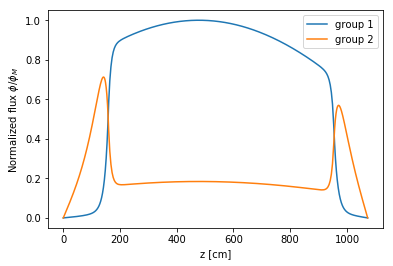

In [16]:
# Build system
Nb = 200
xb = np.linspace(0, 160, num=Nb)
# print(xb)
hb = xb[1]-xb[0]
hb2 = hb**2

Nc = 200
xc = np.linspace(160, 160+793, num=Nc)
# print(xc)
hc = xc[1]-xc[0]
hc2 = hc**2

Nt = 200
xt = np.linspace(160+793, 160+793+120, num=Nt)
# print(xt)
ht = xt[1]-xt[0]
ht2 = ht**2

N = Nb + Nc + Nt
x = np.concatenate([xb, xc, xt])
# print(N)
# print(x)

# Diffusion matrix
D = np.zeros((2*N, 2*N))
DM = diags([1, -2, 1], [-1, 0, 1], shape=(N, N)).toarray()
# Diffusion matrix: g = 1
D[:N, :N] = DM
D[:Nb] *= bD[0]/hb2
D[Nb:Nb+Nc] *= cD[0]/hc2
D[Nb+Nc:Nb+Nc+Nt] *= tD[0]/ht2
# Diffusion matrix: g = 2
D[N:2*N, N:2*N] = DM
D[N:N+Nb] *= bD[1]/hb2
D[N+Nb:N+Nb+Nc] *= cD[1]/hc2
D[N+Nb+Nc:N+Nb+Nc+Nt] *= tD[1]/ht2

# Removal
SR = np.eye(2*N)
# Removal: g = 1
SR[:Nb, :Nb] *= -bsr[0]
SR[Nb:Nb+Nc, Nb:Nb+Nc] *= -csr[0]
SR[Nb+Nc:Nb+Nc+Nt, Nb+Nc:Nb+Nc+Nt] *= -tsr[0]
# Removal: g = 2
SR[N:N+Nb, N:N+Nb] *= -bsr[1]
SR[N+Nb:N+Nb+Nc, N+Nb:N+Nb+Nc] *= -csr[1]
SR[N+Nb+Nc:N+Nb+Nc+Nt, N+Nb+Nc:N+Nb+Nc+Nt] *= -tsr[1]

# In-scattering
aux1 = np.eye(N)
SS = np.zeros((2*N, 2*N))
# In-scattering: g = 1: \Sigma^s_{21}
SS[:N, N:2*N] = aux1
SS[:Nb] *= bss[0]
SS[Nb:Nb+Nc] *= css[0]
SS[Nb+Nc:Nb+Nc+Nt] *= tss[0]
# In-scattering: g = 2: \Sigma^s_{12}
SS[N:2*N, :N] = aux1
SS[N:N+Nb] *= bss[1]
SS[N+Nb:N+Nb+Nc] *= css[1]
SS[N+Nb+Nc:N+Nb+Nc+Nt] *= tss[1]

# Fission
F = np.zeros((2*N,2*N))
# Fission: g = 1
F[Nb:Nb+Nc, Nb:Nb+Nc] = cchi[0] * cnusf[0] * aux1[Nb:Nb+Nc, Nb:Nb+Nc]
F[Nb:Nb+Nc, N+Nb:N+Nb+Nc] = cchi[0] * cnusf[1] * aux1[Nb:Nb+Nc, Nb:Nb+Nc]
# Fission: g = 2
F[N+Nb:N+Nb+Nc, Nb:Nb+Nc] = cchi[1] * cnusf[0] * aux1[Nb:Nb+Nc, Nb:Nb+Nc]
F[N+Nb:N+Nb+Nc, N+Nb:N+Nb+Nc] = cchi[1] * cnusf[1] * aux1[Nb:Nb+Nc, Nb:Nb+Nc]

# Apply BCs
LHS = D + SR + SS

# group 1
LHS[0] = np.zeros(2*N)
LHS[0, 0] = 1.0

LHS[Nb-1] = np.zeros(2*N)
LHS[Nb-1, Nb-3] = 1./2/hb*bD[0]
LHS[Nb-1, Nb-2] = -2./hb*bD[0]
LHS[Nb-1, Nb-1] = 3./2/hb*bD[0]
LHS[Nb-1, Nb] = 3./2/hc*cD[0]
LHS[Nb-1, Nb+1] = -2./hc*cD[0]
LHS[Nb-1, Nb+2] = 1./2/hc*cD[0]

LHS[Nb] = np.zeros(2*N)
LHS[Nb, Nb-1] = -1.0
LHS[Nb, Nb] = 1.0

LHS[Nb+Nc-1] = np.zeros(2*N)
LHS[Nb+Nc-1, Nb+Nc-3] = 1./2/hc*cD[0]
LHS[Nb+Nc-1, Nb+Nc-2] = -2./hc*cD[0]
LHS[Nb+Nc-1, Nb+Nc-1] = 3./2/hc*cD[0]
LHS[Nb+Nc-1, Nb+Nc] = 3./2/ht*tD[0]
LHS[Nb+Nc-1, Nb+Nc+1] = -2./ht*tD[0]
LHS[Nb+Nc-1, Nb+Nc+2] = 1./2/ht*tD[0]

LHS[Nb+Nc] = np.zeros(2*N)
LHS[Nb+Nc, Nb+Nc-1] = -1.0
LHS[Nb+Nc, Nb+Nc] = 1.0

LHS[Nb+Nc+Nt-1] = np.zeros(2*N)
LHS[Nb+Nc+Nt-1, Nb+Nc+Nt-1] = 1.0

# group 2
LHS[N] = np.zeros(2*N)
LHS[N, N] = 1.0

LHS[N+Nb-1] = np.zeros(2*N)
LHS[N+Nb-1, N+Nb-3] = 1./2/hb*bD[1]
LHS[N+Nb-1, N+Nb-2] = -2./hb*bD[1]
LHS[N+Nb-1, N+Nb-1] = 3./2/hb*bD[1]
LHS[N+Nb-1, N+Nb] = 3./2/hc*cD[1]
LHS[N+Nb-1, N+Nb+1] = -2./hc*cD[1]
LHS[N+Nb-1, N+Nb+2] = 1./2/hc*cD[1]

LHS[N+Nb] = np.zeros(2*N)
LHS[N+Nb, N+Nb-1] = -1.0
LHS[N+Nb, N+Nb] = 1.0

LHS[N+Nb+Nc-1] = np.zeros(2*N)
LHS[N+Nb+Nc-1, N+Nb+Nc-3] = 1./2/hc*cD[1]
LHS[N+Nb+Nc-1, N+Nb+Nc-2] = -2./hc*cD[1]
LHS[N+Nb+Nc-1, N+Nb+Nc-1] = 3./2/hc*cD[1]
LHS[N+Nb+Nc-1, N+Nb+Nc] = 3./2/ht*tD[1]
LHS[N+Nb+Nc-1, N+Nb+Nc+1] = -2./ht*tD[1]
LHS[N+Nb+Nc-1, N+Nb+Nc+2] = 1./2/ht*tD[1]

LHS[N+Nb+Nc] = np.zeros(2*N)
LHS[N+Nb+Nc, N+Nb+Nc-1] = -1.0
LHS[N+Nb+Nc, N+Nb+Nc] = 1.0

LHS[N+Nb+Nc+Nt-1] = np.zeros(2*N)
LHS[N+Nb+Nc+Nt-1, N+Nb+Nc+Nt-1] = 1.0

#
F[0] = np.zeros(2*N)
F[Nb-1] = np.zeros(2*N)
F[Nb] = np.zeros(2*N)
F[Nb+Nc-1] = np.zeros(2*N)
F[Nb+Nc] = np.zeros(2*N)
F[Nb+Nc+Nt-1] = np.zeros(2*N)

F[N] = np.zeros(2*N)
F[N+Nb-1] = np.zeros(2*N)
F[N+Nb] = np.zeros(2*N)
F[N+Nb+Nc-1] = np.zeros(2*N)
F[N+Nb+Nc] = np.zeros(2*N)
F[2*N-1] = np.zeros(2*N)

k = 1.0
flux_old = np.ones(2*N)
RHS = -F @ flux_old

def converged(k_old, k):
    if abs((k - k_old)/k_old) <= 1e-10:
        return True
    else:
        return False

for i in range(1000):
    k_old = k
    flux_new = np.linalg.solve(LHS, RHS)
    kp = sum(F @ flux_new)/sum(F @ flux_old)
    k = k_old * kp
    RHS = -(1./k) * F @ flux_new
    flux_old = flux_new
    if converged(k_old, k) == True:
        break

print('i = ', i)
print('k = ', k)
flux = flux_old
# print(flux)
flux1 = flux[:N]
flux2 = flux[N:2*N]

flux1 = flux_old[:N]
M = max(flux1)
flux1 /= M
flux2 = flux_old[N:2*N]
flux2 /= M

plt.plot(x, flux1, label='group 1')
plt.plot(x, flux2, label='group 2')
plt.legend(loc='upper right')
plt.ylabel(r"Normalized flux $\phi/\phi_M$")
plt.xlabel("z [cm]")
# plt.savefig("1D-fuel-reflec-eig-FDM", dpi=300, bbox_inches="tight")
plt.savefig("1D-assembly-eig-FDM2", dpi=300, bbox_inches="tight")
plt.show()